In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# read in data, last column is target 1: is spam, 0: is not spam

df = pd.read_csv('spambase.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [46]:
df.shape

(4601, 58)

In [50]:
# randomize data, split into training and validation

data_np = df.to_numpy()
np.random.seed(0)
np.random.shuffle(data_np)

trainSplit = int(np.ceil(len(data_np) * (2/3)))
training, validation = data_np[:trainSplit], data_np[trainSplit:]
x_train, y_train = training[:, :-1], training[:, -1:]
x_valid, y_valid = validation[:, :-1], validation[:, -1:]


In [51]:
# z-score training data and add bias feature

mean = np.mean(x_train, axis=0, keepdims=True)
std = np.std(x_train, axis=0, ddof=1, keepdims=True)

ztrain = (x_train - mean) / std
zvalid = (x_valid - mean) / std

ztrain = np.hstack((np.ones((ztrain.shape[0], 1)), ztrain))
zvalid = np.hstack((np.ones((zvalid.shape[0], 1)), zvalid))

In [52]:
# sigmoid function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [53]:
# log loss function

def logLoss(predictions, true_value, epsilon):
    return -np.mean(true_value * np.log(predictions + epsilon) + (1 - true_value) * np.log(1 - predictions + epsilon))


In [54]:
# logistic regression fucntion

def logisticRegression(featureTraining, targetTraining, featureValidation, weights, learning_rate, epochs, epsilon):

    trainingLogLosses = []
    validationLogLosses = []

    for i in range(epochs):

        # training and validation predicitons
        trainingPrediction = sigmoid(featureTraining @ weights) 
        validationPrediction = sigmoid(featureValidation @ weights)

        # calculate gradient and update weights
        gradient = (1 / len(featureTraining)) * ((featureTraining.T) @ (trainingPrediction - targetTraining))
        weights -= (learning_rate * gradient) 
        
        # calculate log-loss for training and validaiton data
        trainingLogLosses.append(logLoss(trainingPrediction, y_train, epsilon))
        validationLogLosses.append(logLoss(validationPrediction, y_valid, epsilon))

        if i > 0 and (np.abs(trainingLogLosses[-2] - trainingLogLosses[-1]) < epsilon 
                      or np.abs(validationLogLosses[-2] - validationLogLosses[-1] < epsilon)):
            break

    return weights, trainingLogLosses, validationLogLosses


In [55]:
# compute accuracy for both training and validation data

def statistics(prediction, true_value):
    
    truePositive, falsePositive, trueNegative, falseNegative, correct = 0, 0, 0, 0, 0

    for i in range(len(prediction)):
        if prediction[i] == 1 and true_value[i] == 1:
            correct += 1
            truePositive += 1

        elif prediction[i] == 1 and true_value[i] == 0:
            falsePositive += 1

        elif prediction[i] == 0 and true_value[i] == 0:
            correct += 1
            trueNegative += 1

        else:
            falseNegative += 1

    percentage_correct = (correct / len(prediction)) * 100
    precision = truePositive / (truePositive + falsePositive)
    recall = truePositive / (truePositive + falseNegative)
    fmeasure = (2 * precision * recall) / (precision + recall)

    return percentage_correct, precision, recall, fmeasure

In [56]:
# logistic regression

# initialize weights to random numbers in the range of +-10^-4
weight = np.random.uniform(-1e-4, 1e-4, (ztrain.shape[1], 1))
finalWeight, trainingLogLoss, validLogLoss = logisticRegression(ztrain, y_train, zvalid, weight, 0.1, 30000, 1e-7)

In [57]:
# classify training and validation (>=50%)

trainingPrediciton = [0 if output < 0.5 else 1 for output in sigmoid(ztrain @ finalWeight)] 
validationPrediction = [0 if output < 0.5 else 1 for output in sigmoid(zvalid @ finalWeight)]

In [58]:
# get statistics for training and validaiton data

traininingAccuracy, trainingPrecision, trainingRecall, trainingFmeasure = statistics(trainingPrediciton, y_train)
validationAccuracy, validationPrecision, validationRecall, validationFmeasure = statistics(validationPrediction, y_valid)

print('Training Accuracy: {}%'.format(traininingAccuracy))
print('Validation Accuracy: {}%\n'.format(validationAccuracy))
print('Validation Precision: {}'.format(validationPrecision))
print('Validaiton Recall: {}'.format(validationRecall))
print('Vaidaiton F-Measure: {}'.format(validationFmeasure))

Training Accuracy: 92.79661016949152%
Validation Accuracy: 93.02022178734506%

Validation Precision: 0.9064124783362218
Validaiton Recall: 0.9079861111111112
Vaidaiton F-Measure: 0.9071986123156983


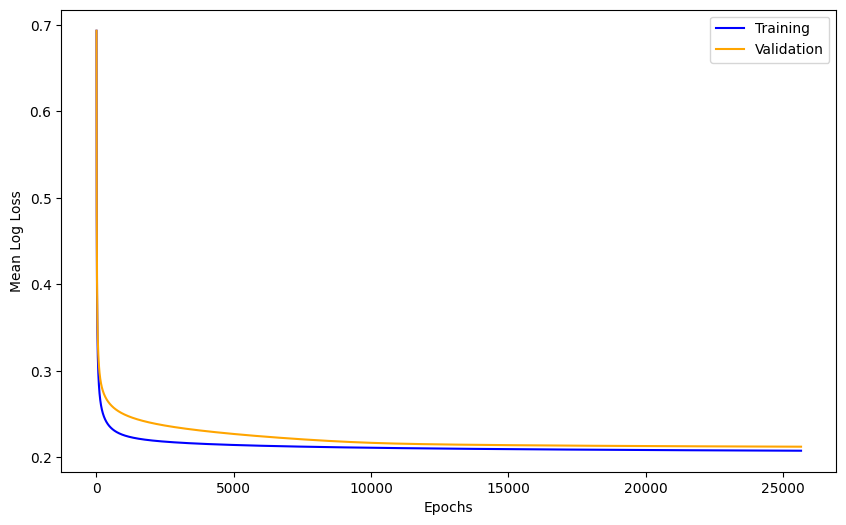

In [59]:
# plot log-loss

epochs_range = range(1, len(trainingLogLoss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, trainingLogLoss, label='Training', color='blue')
plt.plot(epochs_range, validLogLoss, label='Validation', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Log Loss')
plt.legend()
plt.show()